# Bias-variance trade-off

Measure bias and variance for a tiny subsample of a test set. We avg the error from each prediction and if test set is too big not seeing very high variance due to avg smoothing.

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from sklearn import tree
from dtreeviz.trees import *

### Regression

In [2]:
# can't use too many records as model.score() will be average of many values
# which reduces variance; we're trying to highlight not hide that variance
df_rent = pd.read_csv("data/rent-ideal.csv", nrows=4000)
X = df_rent[['bedrooms','bathrooms','latitude','longitude']]
y = df_rent['price']
X.head()

,bedrooms,bathrooms,latitude,longitude
0,3,1.5,40.7145,-73.9425
1,2,1.0,40.7947,-73.9667
2,1,1.0,40.7388,-74.0018
3,1,1.0,40.7539,-73.9677
4,4,1.0,40.8241,-73.9493


In [3]:
def rent():
    # can't use too many records as model.score() will be average of many values
    # which reduces variance; we're trying to highlight not hide that variance
    df_rent = pd.read_csv("data/rent-ideal.csv")
    X = df_rent[['bedrooms','bathrooms','latitude','longitude']].values
    y = df_rent['price'].values

    # shuffle
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]
    return X, y

def testobs(X, y, nchunks = 200, ntests=5):
    n = len(X)
    chunk_size = n // nchunks

    # grab say just 5 records; too many and average r2 over test set shows too little variance
    if chunk_size<ntests:
        raise "Oops"
    X_test, y_test = X[0:ntests], y[0:ntests]
    return X_test, y_test, chunk_size

In [4]:
nchunks = 50
X, y = rent()
X_test, y_test, chunk_size = testobs(X, y, nchunks=nchunks, ntests=10)

In [5]:
leaf_sizes = range(1,100)

all_test_scores = np.zeros(shape=(len(leaf_sizes), nchunks-1)) # first chunk is test set
for i,min_samples_leaf in enumerate(leaf_sizes):
#     print(f"min_samples_leaf={min_samples_leaf}: ", end='')
    test_scores = []
    for j in range(1,nchunks): # first chunk is test set; skip
#         print(j,' ', end='')
        X_train = X[j*chunk_size:j*chunk_size+chunk_size]
        y_train = y[j*chunk_size:j*chunk_size+chunk_size]
        t = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf)
        t.fit(X_train, y_train)
        s = t.score(X_test, y_test)
        test_scores.append(s)

    all_test_scores[i] = test_scores
    avg = np.mean(test_scores)
    std = np.std(test_scores)
#     print(avg, std)

In [6]:
test_means = np.mean(all_test_scores, axis=1)
test_variances = np.std(all_test_scores, axis=1)

Text(0.5, 1.0, 'NYC Rent decision tree bias-stddev vs leaf size')

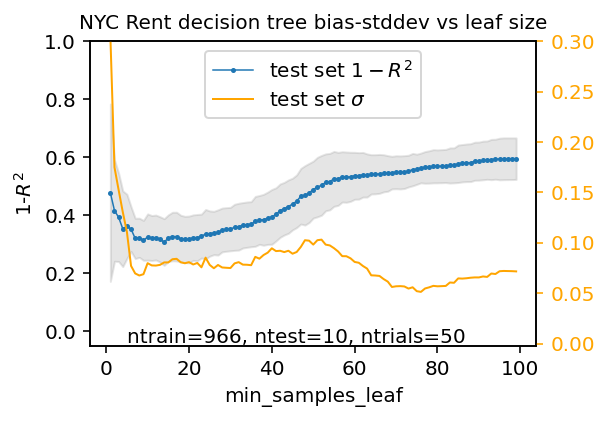

In [7]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)

a = ax.plot(leaf_sizes, 1-test_means, lw=.75, marker='.', markersize=3, label="test set $1-R^2$")

plt.fill_between(leaf_sizes, 
                 1-test_means - test_variances,
                 1-test_means + test_variances,
                 color='gray', alpha=0.2)

ax2 = ax.twinx()
b = ax2.plot(leaf_sizes, test_variances, lw=1, label="test set $\sigma$", c='orange')
ax2.yaxis.label.set_color('orange')
#ax2.set_ylabel("Test $\sigma$")
ax2.tick_params(axis='y', colors='orange')
ax2.set_ylim(-0.002,0.3)

ax.set_xlabel("min_samples_leaf")
ax.set_ylabel("1-$R^2$")
ax.set_ylim(-.05,1.0)
lines = a+b
labels = [l.get_label() for l in lines]
ax.legend(lines,labels,loc='upper center')

ax.text(5,-.04,f"ntrain={len(X_train)}, ntest={len(X_test)}, ntrials={nchunks}")

ax.set_title("NYC Rent decision tree bias-stddev vs leaf size", fontsize=10)

### Classification

In [8]:
digits = load_digits()

df_digits = pd.DataFrame(data=digits.data)
df_digits['digit'] = digits.target
df_digits = df_digits.sample(n=len(df_digits))
X = df_digits.drop('digit', axis=1)
y = df_digits['digit']

nchunks = 10
X_test, y_test, chunk_size = testobs(X, y, nchunks=nchunks, ntests=100)

In [9]:
leaf_sizes = range(1,100+1)

all_test_scores = np.zeros(shape=(len(leaf_sizes), nchunks-1)) # first chunk is test set
for i,min_samples_leaf in enumerate(leaf_sizes):
#     print(f"min_samples_leaf={min_samples_leaf}: ", end='')
    test_scores = []
    for j in range(1,nchunks): # first chunk is test set; skip
#         print(j,' ', end='')
        X_train = X[j*chunk_size:j*chunk_size+chunk_size]
        y_train = y[j*chunk_size:j*chunk_size+chunk_size]
        t = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
        t.fit(X_train, y_train)
        s = t.score(X_test, y_test)
        test_scores.append(s)

    all_test_scores[i] = test_scores
    avg = np.mean(test_scores)
    std = np.std(test_scores)
#     print(avg, std)

In [10]:
test_means = np.mean(all_test_scores, axis=1)
test_variances = np.std(all_test_scores, axis=1)

Text(0.5, 1.0, 'MNIST decision tree bias-stddev vs leaf size')

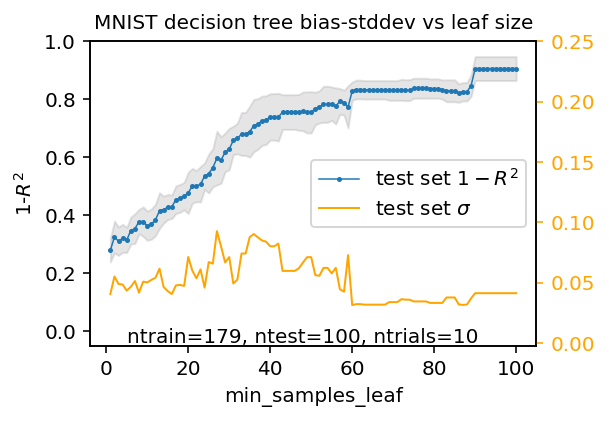

In [11]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)

a = ax.plot(leaf_sizes, 1-test_means, lw=.75, marker='.', markersize=3, label="test set $1-R^2$")

plt.fill_between(leaf_sizes, 
                 1-test_means - test_variances,
                 1-test_means + test_variances,
                 color='gray', alpha=0.2)

ax2 = ax.twinx()
b = ax2.plot(leaf_sizes, test_variances, lw=1, label="test set $\sigma$", c='orange')
ax2.yaxis.label.set_color('orange')
#ax2.set_ylabel("Test $\sigma$")
ax2.tick_params(axis='y', colors='orange')
ax2.set_ylim(-0.002,0.25)

ax.set_xlabel("min_samples_leaf")
ax.set_ylabel("1-$R^2$")
ax.set_ylim(-.05,1.0)
lines = a+b
labels = [l.get_label() for l in lines]
ax.legend(lines,labels,loc='center right')

ax.text(5,-0.04,f"ntrain={len(X_train)}, ntest={len(X_test)}, ntrials={nchunks}")

ax.set_title("MNIST decision tree bias-stddev vs leaf size", fontsize=10)

## Error sources diagrams

Text(0.5, 1.0, 'Perfect $y = f(X) = (X-2)^2$ data')

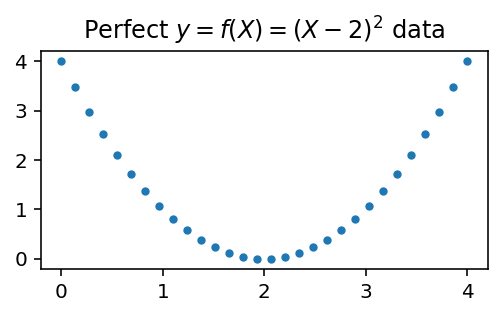

In [12]:
X = np.linspace(0,4,30)
y = (X-2)**2
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10)
ax.set_title("Perfect $y = f(X) = (X-2)^2$ data")

Text(0.5, 1.0, 'Inconsistent $y = f(X) = (X-2)^2$ data')

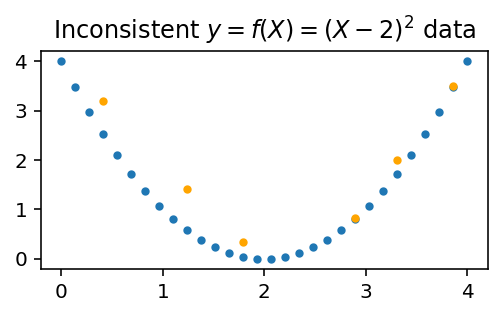

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10)
for i in [3,9,13,21,24,28]:
    ax.scatter([X[i]],[y[i]+np.random.rand()],s=10,c='orange')
ax.set_title("Inconsistent $y = f(X) = (X-2)^2$ data")

In [14]:
X = np.linspace(0,4,30)
y = (X-2)**2 + np.random.random(size=len(X))*1.5

Text(0.5, 1.0, 'Noisy $y = f(X) = (X-2)^2 + \\epsilon$ data')

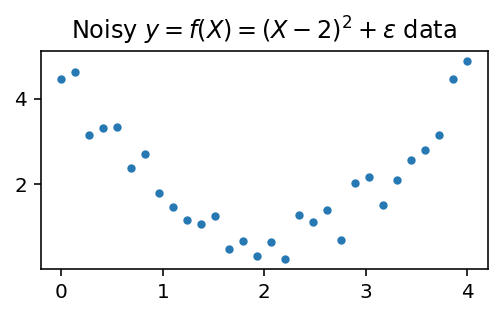

In [15]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.set_title("Noisy $y = f(X) = (X-2)^2 + \epsilon$ data")

Text(0.5, 1.0, 'Underfit (shallow) decision tree')

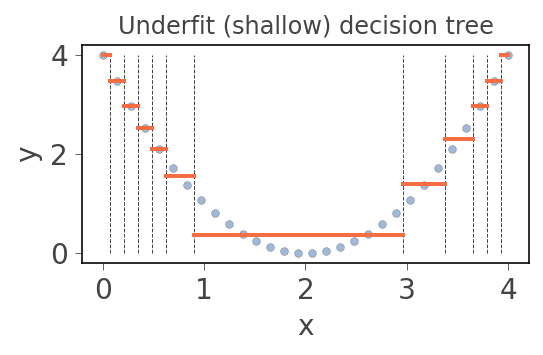

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *

X = np.linspace(0,4,30).reshape(-1,1)
y = (X-2)**2

dt = DecisionTreeRegressor(max_depth=4)
dt.fit(X, y)

fig, ax = plt.subplots(1,1, figsize=(4,2))
rtreeviz_univar(dt, X, y, 'x', 'y', ax=ax)
ax.set_title("Underfit (shallow) decision tree")

In [38]:
X = np.linspace(0,4,30)
y_ = (X-2)**2 + np.random.random(size=X.shape[0])*1.5
X = X.reshape(-1,1)

Text(0.5, 1.0, 'Noisy data (shallow) decision tree')

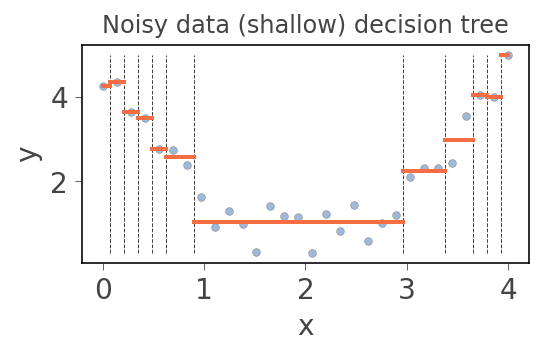

In [39]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
rtreeviz_univar(dt, X, y_, 'x', 'y', ax=ax)
ax.set_title("Noisy data (shallow) decision tree")

Text(0.5, 1.0, 'Underfit')

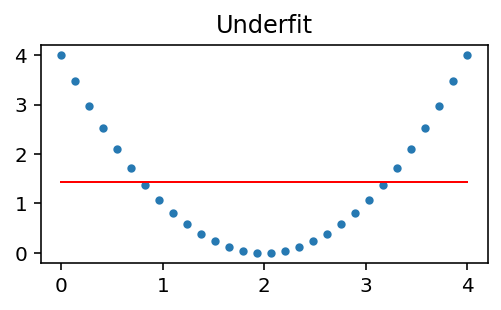

In [18]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,(X-2)**2,s=10,c='#2679B2')
ax.plot([0,4], [np.mean(y)]*2, c='red',lw=1)
ax.set_title("Underfit")

Text(0.5, 1.0, 'Underfit')

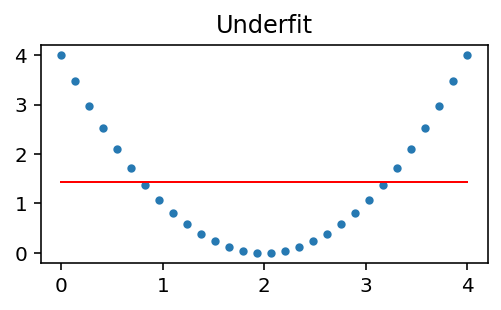

In [19]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.plot([0,4], [np.mean(y)]*2, c='red',lw=1)
ax.set_title("Underfit")

Text(0.5, 1.0, 'Balanced model')

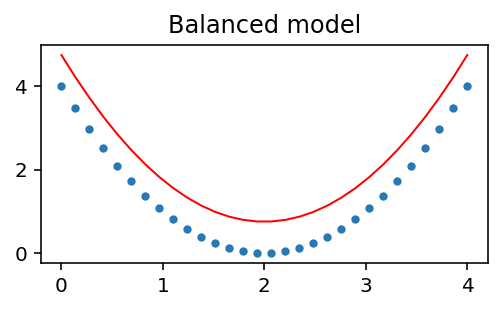

In [20]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.plot(X,(X-2)**2+.75, c='red',lw=1)
ax.set_title("Balanced model")

Text(0.5, 1.0, 'Overfit model')

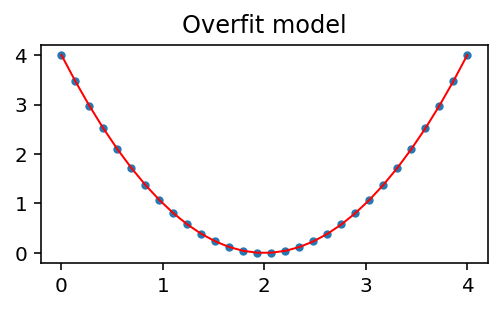

In [21]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.plot(X,y,c='red',lw=1)
ax.set_title("Overfit model")

In [22]:
# do overfitting on non-noisy data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

X = np.linspace(0,4,30)
y = (X-2)**2 + np.random.random(size=len(X))

model = Pipeline([('poly', PolynomialFeatures(degree=27)),
                  ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-3 polynomial data
#y = 3 - 2 * X + X ** 2 - X ** 3
model = model.fit(X[:, np.newaxis], y)
coef = model.named_steps['linear'].coef_
coef

array([ 4.98763222e-01,  5.23891792e-01,  3.96393953e-01,  3.24996506e-01,
        2.68239717e-01,  2.09569379e-01,  1.41228828e-01,  6.17242732e-02,
       -2.32192998e-02, -9.93389283e-02, -1.44979768e-01, -1.37916983e-01,
       -6.96807228e-02,  3.65792284e-02,  1.19511116e-01,  1.07649940e-01,
       -9.41231541e-03, -1.19843972e-01, -6.51195738e-02,  1.05596399e-01,
        6.61797066e-02, -1.50202257e-01,  1.01355806e-01, -3.77341284e-02,
        8.61651994e-03, -1.20872941e-03,  9.61868142e-05, -3.33894801e-06])

Text(0.5, 1.0, 'Overfit degree 27 polynomial on noisy data')

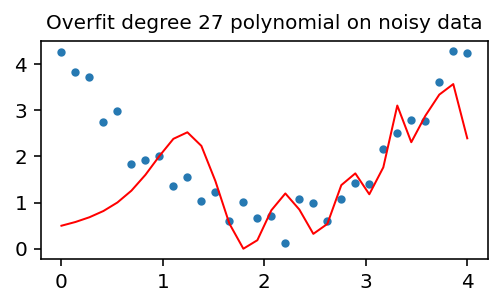

In [23]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
#ax.plot(X,coef[0]+coef[1]*X + coef[2]*X**2 + coef[3]*X**3)
ax.plot(X,model.predict(X.reshape(-1,1)), c='red', lw=1)
ax.set_title("Overfit degree 27 polynomial on noisy data", fontsize=10)

Text(0.5, 1.0, 'Ensemble of overfit models')

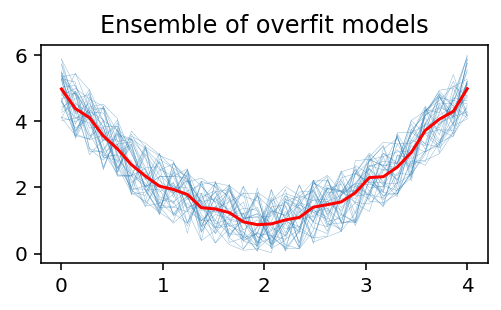

In [24]:
X = np.linspace(0,4,30)
ntrials = 35
fig, ax = plt.subplots(1,1, figsize=(4,2))
ys = np.zeros(shape=(ntrials,len(X)))
for i in range(ntrials):
    y = (X-2)**2 + np.random.random(size=len(X))*2.0
    ys[i] = y
#    ax.scatter(X,y,s=.25,c='#2679B2')
    ax.plot(X,y,c='#2679B2',lw=.25, alpha=.5)

y_avg = np.mean(ys,axis=0)
#ax.scatter(X,y,s=.5,c='#2679B2')
ax.plot(X,y_avg,c='red',lw=1.5)

#ax.set_title("Overfit model")
ax.set_title("Ensemble of overfit models")